In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = "dataset/retinal_scan/retinal_image/retino/train/"
val_path = "dataset/retinal_scan/retinal_image/retino/valid/"
test_path = "dataset/retinal_scan/retinal_image/retino/test/"

## Importing Data

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
    

In [4]:
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    shuffle=True,
    class_mode='binary',
    batch_size=16
)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    class_mode='binary',
    batch_size=16
)
val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    class_mode='binary',
    batch_size=16
)    

Found 2076 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Found 531 images belonging to 2 classes.


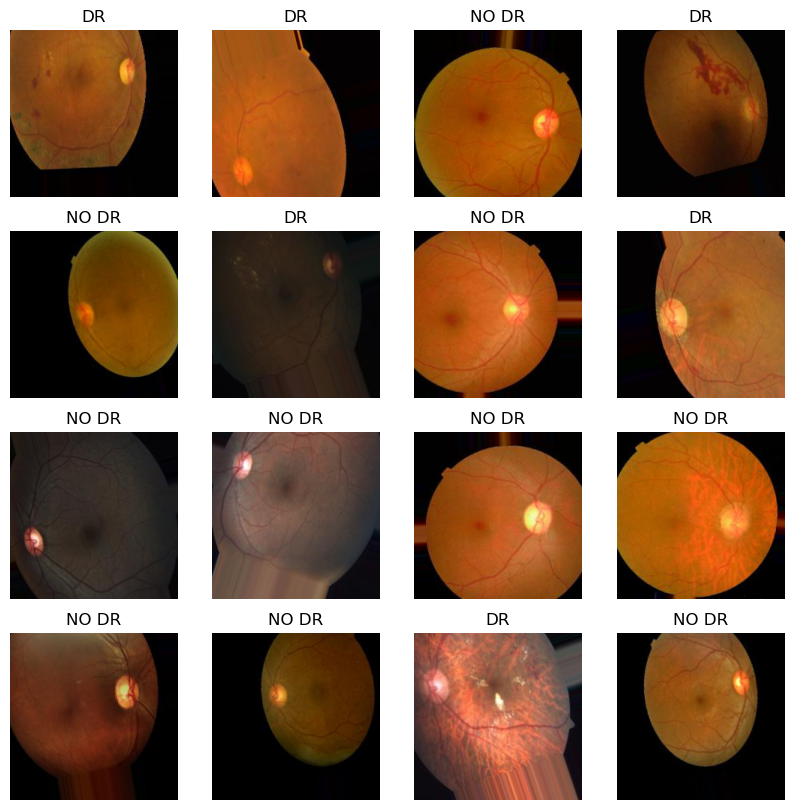

In [5]:
images,labels = next(train_data)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title("NO DR" if labels[i]==1 else "DR")
    plt.axis("off")
plt.show()

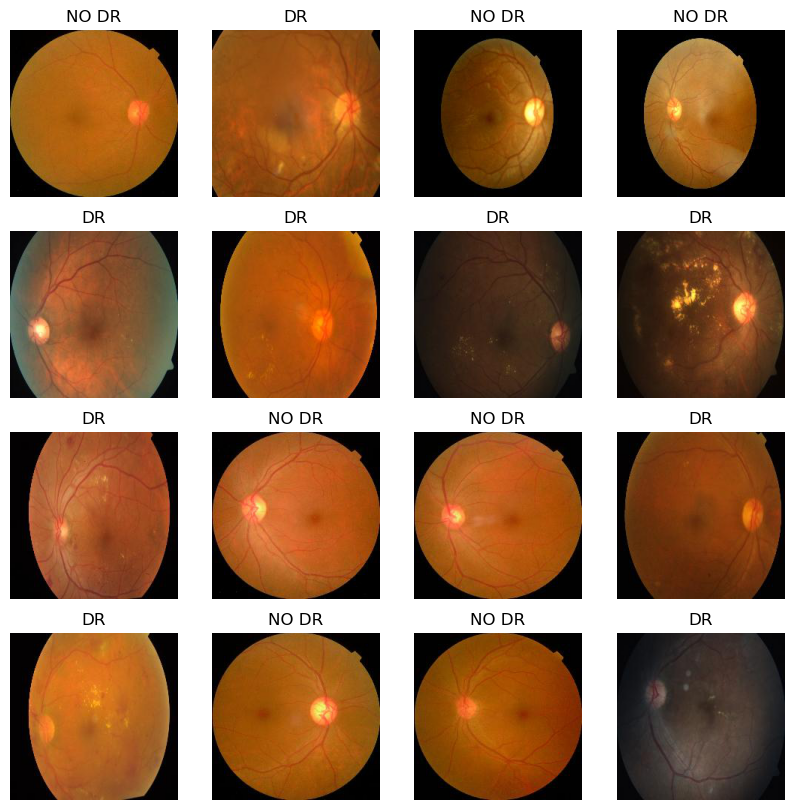

In [6]:
images,labels = next(val_data)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title("NO DR" if labels[i]==1 else "DR")
    plt.axis("off")
plt.show()

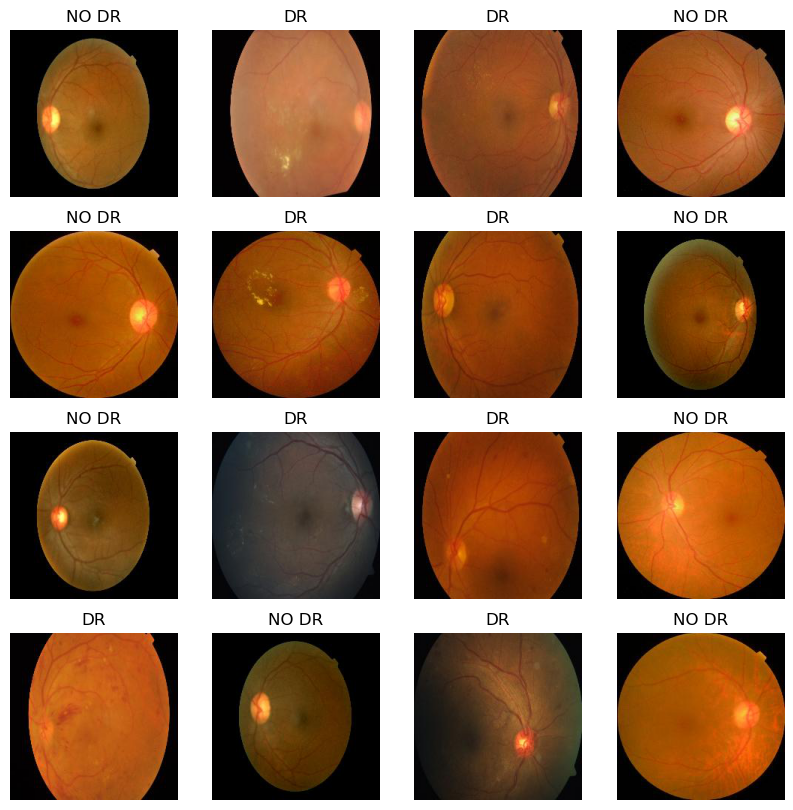

In [7]:
images,labels = next(test_data)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title("NO DR" if labels[i]==1 else "DR")
    plt.axis("off")
plt.show()

# VGG16 model
## Importing the model and freezing the layers

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top = False, input_shape=(224,224,3))
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
______________________________________

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

## Training with 25 epochs

In [13]:
history = model.fit(train_data, epochs=25, validation_data=val_data, verbose=2)

Epoch 1/25
130/130 - 23s - loss: 0.1983 - accuracy: 0.9253 - val_loss: 0.1826 - val_accuracy: 0.9266 - 23s/epoch - 173ms/step
Epoch 2/25
130/130 - 20s - loss: 0.1862 - accuracy: 0.9321 - val_loss: 0.2112 - val_accuracy: 0.9266 - 20s/epoch - 156ms/step
Epoch 3/25
130/130 - 19s - loss: 0.1899 - accuracy: 0.9306 - val_loss: 0.1972 - val_accuracy: 0.9247 - 19s/epoch - 150ms/step
Epoch 4/25
130/130 - 22s - loss: 0.1915 - accuracy: 0.9282 - val_loss: 0.1922 - val_accuracy: 0.9209 - 22s/epoch - 166ms/step
Epoch 5/25
130/130 - 20s - loss: 0.1815 - accuracy: 0.9355 - val_loss: 0.1918 - val_accuracy: 0.9303 - 20s/epoch - 151ms/step
Epoch 6/25
130/130 - 20s - loss: 0.1811 - accuracy: 0.9355 - val_loss: 0.2097 - val_accuracy: 0.9247 - 20s/epoch - 153ms/step
Epoch 7/25
130/130 - 19s - loss: 0.1772 - accuracy: 0.9427 - val_loss: 0.1881 - val_accuracy: 0.9379 - 19s/epoch - 150ms/step
Epoch 8/25
130/130 - 20s - loss: 0.1793 - accuracy: 0.9408 - val_loss: 0.1760 - val_accuracy: 0.9341 - 20s/epoch - 151

In [28]:
def plot_model_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],label = 'Training Loss')
    plt.plot(history.history['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


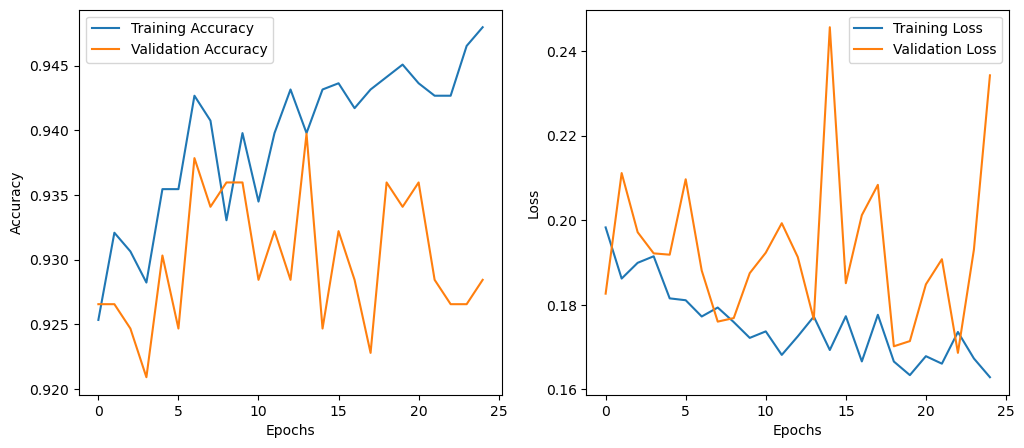

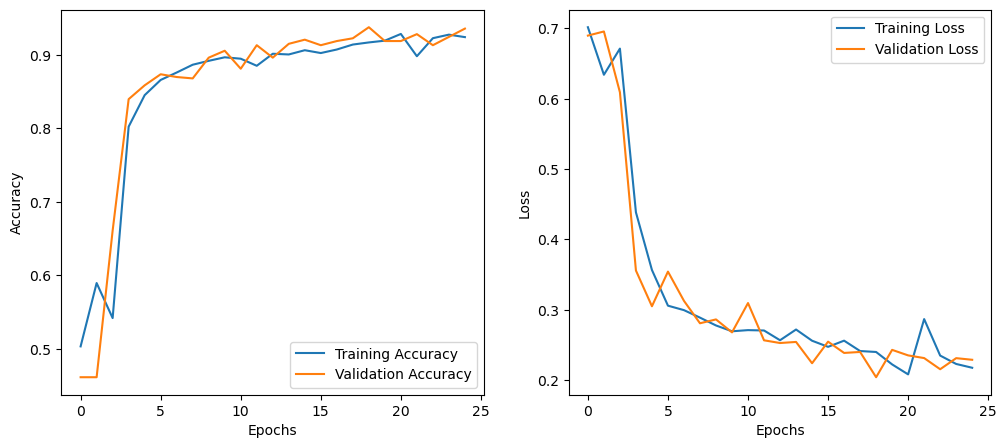

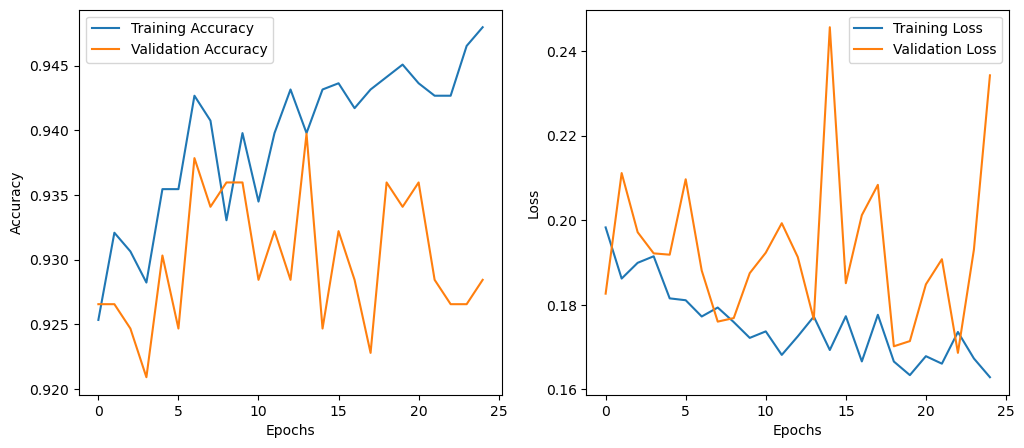

In [29]:
plot_model_history(history)

## Evaluating the model

In [22]:
loss, accuracy = model.evaluate(test_data)

15/15 [==============================] - 3s 217ms/step - loss: 0.1956 - accuracy: 0.9307


# Fine tuning the VGG16 model and then train with 25 epochs

In [23]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freezing all layer exept the last 4
for layer in vgg_model.layers[-4:]:
    layer.trainable=False
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Creating New model 

In [24]:
model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    vgg_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 7,898,433
Non-trainable params: 7,079,424
___________________________________

In [25]:
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy']
              )

In [26]:
history2 = model2.fit(train_data, epochs=25, validation_data=val_data, verbose=2)

Epoch 1/25
130/130 - 35s - loss: 0.7017 - accuracy: 0.5034 - val_loss: 0.6897 - val_accuracy: 0.4614 - 35s/epoch - 272ms/step
Epoch 2/25
130/130 - 30s - loss: 0.6341 - accuracy: 0.5896 - val_loss: 0.6956 - val_accuracy: 0.4614 - 30s/epoch - 230ms/step
Epoch 3/25
130/130 - 30s - loss: 0.6713 - accuracy: 0.5419 - val_loss: 0.6092 - val_accuracy: 0.6610 - 30s/epoch - 231ms/step
Epoch 4/25
130/130 - 30s - loss: 0.4385 - accuracy: 0.8025 - val_loss: 0.3558 - val_accuracy: 0.8399 - 30s/epoch - 231ms/step
Epoch 5/25
130/130 - 30s - loss: 0.3566 - accuracy: 0.8454 - val_loss: 0.3050 - val_accuracy: 0.8588 - 30s/epoch - 231ms/step
Epoch 6/25
130/130 - 30s - loss: 0.3058 - accuracy: 0.8661 - val_loss: 0.3543 - val_accuracy: 0.8738 - 30s/epoch - 231ms/step
Epoch 7/25
130/130 - 30s - loss: 0.2995 - accuracy: 0.8762 - val_loss: 0.3127 - val_accuracy: 0.8701 - 30s/epoch - 231ms/step
Epoch 8/25
130/130 - 30s - loss: 0.2888 - accuracy: 0.8868 - val_loss: 0.2808 - val_accuracy: 0.8682 - 30s/epoch - 231

In [27]:
plot_model_history(history2)